<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *AIB / SECTION 2 / SPRINT 3 / NOTE 4*

# 📝 Assignment
---

# 🌱 **기본 과제**

In [ ]:
!pip install category_encoders 

In [ ]:
!pip3 install xgboost==1.7.2

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from category_encoders import OrdinalEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

## **Part 1. 데이터 준비**
- 데이터셋을 불러오세요.
  - 데이터셋에 대한 정보는 다음 링크에서 확인할 수 있습니다. <br>
    https://www.kaggle.com/datasets/ifteshanajnin/carinsuranceclaimprediction-classification?select=train.csv 
  - 결측치 및 중복된 데이터는 확인 후 제거해 주세요. 
- 불필요한 column은 제거해 주세요.
  - `policy_id`, `area_cluster`, `make`, `model`, `fuel_type`, `airbags`, `cylinder` column을 제거합니다. 
- target의 분포를 확인하세요.
  - target은 `is_claim`입니다. 
- train/val set으로 분리하세요.  
  - train/val set의 비율은 8:2로 설정하세요.
  - `random_state=42`로 설정하세요. 
  - target의 class 비율이 유지되도록 분리하세요. 

In [ ]:
# 데이터셋 불러오기 

df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/temp/train.csv')
df

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,...,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58587,ID58588,0.355089,0.13,0.644231,C8,8794,2,A,M3,Petrol,...,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0
58588,ID58589,1.199642,0.02,0.519231,C14,7788,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
58589,ID58590,1.162273,0.05,0.451923,C5,34738,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
58590,ID58591,1.236307,0.14,0.557692,C8,8794,1,B2,M6,Petrol,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0


In [ ]:
df.info() # 결측치는 없습니다. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  object 
 1   policy_tenure                     58592 non-null  float64
 2   age_of_car                        58592 non-null  float64
 3   age_of_policyholder               58592 non-null  float64
 4   area_cluster                      58592 non-null  object 
 5   population_density                58592 non-null  int64  
 6   make                              58592 non-null  int64  
 7   segment                           58592 non-null  object 
 8   model                             58592 non-null  object 
 9   fuel_type                         58592 non-null  object 
 10  max_torque                        58592 non-null  object 
 11  max_power                         58592 non-null  object 
 12  engi

In [ ]:
df.duplicated().sum() # 중복된 데이터는 없습니다.

0

In [ ]:
df.drop(columns=["policy_id", "area_cluster", "make", "model", "fuel_type", "airbags", "cylinder"], inplace=True)

df.shape

(58592, 37)

In [ ]:
target = 'is_claim'
df[target].value_counts(normalize=True) # 타겟 데이터 비율이 매우 불균형합니다. 

0    0.936032
1    0.063968
Name: is_claim, dtype: float64

In [ ]:
print('Baseline Accuracy:', max(df[target].value_counts(normalize=True)))

Baseline Accuracy: 0.9360322228290552


In [ ]:
# train/val set 분리
train, val = train_test_split(df, test_size=0.2, stratify=df[target], random_state=42)
print(train.shape, val.shape)

(46873, 37) (11719, 37)


In [ ]:
# target의 class 비율 확인
print("Train target distribution:\n", train[target].value_counts(normalize=True), "\n")
print("Val target distribution:\n", val[target].value_counts(normalize=True))

Train target distribution:
 0    0.93604
1    0.06396
Name: is_claim, dtype: float64 

Val target distribution:
 0    0.936001
1    0.063999
Name: is_claim, dtype: float64


## **Part 2. Modeling**  

### **2-1. 모델 학습**
- train/val set을 각각 feature와 target으로 분리하세요. 
- 범주형 데이터는 `OrdinalEncoder()`를 적용하여 변환해 주세요.
- `XGBClassifier()`을 사용하여 GBDT 모델을 학습하세요. 
  - `objective="binary:logistic"`으로 설정합니다. 
  - 평가지표는 `"auc"`를 사용합니다. 
  - `n_estimators`는 1000 이상으로 설정합니다. 
  - `random_state=42`로 지정합니다.
- early stopping을 적용하세요.
  - 50 rounds 동안 성능 개선이 없으면 학습을 중지합니다. 

##### **Q1. early stopping을 적용하였을 때, best iteration을 구하세요.**

In [ ]:
# feature/target 분리
X_train, y_train = train.drop(columns=[target]), train[target]
X_val, y_val = val.drop(columns=[target]), val[target]

In [ ]:
# Ordinal Encoding
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

In [ ]:
# model 학습
model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    n_estimators=987654321,
    random_state=42
)

watchlist = [(X_train_encoded, y_train), (X_val_encoded, y_val)]

model.fit(
    X_train_encoded,
    y_train,
    eval_set=watchlist,
    early_stopping_rounds=50,  # 50 rounds 동안 성능 개선이 없으면 학습을 중지합니다.
)

[0]	validation_0-auc:0.65184	validation_1-auc:0.64320
[1]	validation_0-auc:0.66366	validation_1-auc:0.65032
[2]	validation_0-auc:0.67150	validation_1-auc:0.65483
[3]	validation_0-auc:0.67767	validation_1-auc:0.65297
[4]	validation_0-auc:0.68283	validation_1-auc:0.65152
[5]	validation_0-auc:0.68825	validation_1-auc:0.65407
[6]	validation_0-auc:0.69292	validation_1-auc:0.65261
[7]	validation_0-auc:0.69979	validation_1-auc:0.65250
[8]	validation_0-auc:0.70336	validation_1-auc:0.65448
[9]	validation_0-auc:0.70724	validation_1-auc:0.65577
[10]	validation_0-auc:0.70996	validation_1-auc:0.65645
[11]	validation_0-auc:0.71411	validation_1-auc:0.65769
[12]	validation_0-auc:0.71734	validation_1-auc:0.65592
[13]	validation_0-auc:0.71969	validation_1-auc:0.65510
[14]	validation_0-auc:0.72043	validation_1-auc:0.65477
[15]	validation_0-auc:0.72430	validation_1-auc:0.65724
[16]	validation_0-auc:0.72640	validation_1-auc:0.65730
[17]	validation_0-auc:0.72769	validation_1-auc:0.65680
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=987654321,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [ ]:
model.best_iteration

11

### **2-2. 성능 평가**
- val set에 대하여 AUC score를 구하세요.
- `classification_report()`를 사용하여 성능을 확인하세요.
- confusion matrix를 그려 보세요.

##### **Q2. confusion matrix에서 TP 개수를 제출하세요.**

In [ ]:
def evaluation(model, X_val_encoded, y_val):

    y_pred_proba = model.predict_proba(X_val_encoded, iteration_range=(0, model.best_iteration))[:, 1]
    print("AUC Score:", roc_auc_score(y_val, y_pred_proba), '\n')

    y_pred = model.predict(X_val_encoded, iteration_range=(0, model.best_iteration))
    print(classification_report(y_val, y_pred), '\n')  

    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap='Blues')
    plt.show()

AUC Score: 0.6564490837815662 

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10969
           1       0.00      0.00      0.00       750

    accuracy                           0.94     11719
   macro avg       0.47      0.50      0.48     11719
weighted avg       0.88      0.94      0.91     11719
 



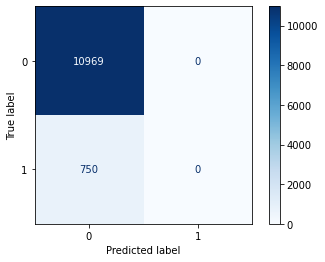

In [ ]:
evaluation(model, X_val_encoded, y_val)

## **Part 3. scale_pos_weight**
- `scale_pos_weight`를 설정하여 GBDT 모델을 다시 학습하세요. 
  - 그 외 하이퍼파라미터 설정은 **Part 2**와 동일합니다. 
  - **Part 2**와 동일하게 early stopping을 적용하세요. 
- 모델의 성능을 확인하세요.
  - val set에 대하여 AUC score를 구하세요.
  - `classification_report()`를 사용하여 성능을 확인하세요.
  - confusion matrix를 그려 보세요.


##### **Q3. confusion matrix에서 TP 개수를 제출하세요.**

In [ ]:
model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    n_estimators=987654321,
    random_state=42,
    scale_pos_weight=(y_val == 0).sum() / (y_val == 1).sum(),
)

watchlist = [(X_train_encoded, y_train), (X_val_encoded, y_val)]

model.fit(
    X_train_encoded,
    y_train,
    eval_set=watchlist,
    early_stopping_rounds=50,  # 50 rounds 동안 성능 개선이 없으면 학습을 중지합니다.
)

[0]	validation_0-auc:0.67583	validation_1-auc:0.63959
[1]	validation_0-auc:0.69300	validation_1-auc:0.64531
[2]	validation_0-auc:0.70140	validation_1-auc:0.64980
[3]	validation_0-auc:0.70508	validation_1-auc:0.65244
[4]	validation_0-auc:0.70839	validation_1-auc:0.64981
[5]	validation_0-auc:0.71611	validation_1-auc:0.65439
[6]	validation_0-auc:0.72154	validation_1-auc:0.65178
[7]	validation_0-auc:0.72539	validation_1-auc:0.65120
[8]	validation_0-auc:0.73051	validation_1-auc:0.65058
[9]	validation_0-auc:0.73381	validation_1-auc:0.64984
[10]	validation_0-auc:0.73666	validation_1-auc:0.64796
[11]	validation_0-auc:0.73824	validation_1-auc:0.64620
[12]	validation_0-auc:0.74381	validation_1-auc:0.64599
[13]	validation_0-auc:0.74580	validation_1-auc:0.64616
[14]	validation_0-auc:0.74642	validation_1-auc:0.64639
[15]	validation_0-auc:0.74934	validation_1-auc:0.64599
[16]	validation_0-auc:0.75273	validation_1-auc:0.64254
[17]	validation_0-auc:0.75499	validation_1-auc:0.64262
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=987654321,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42, ...)

AUC Score: 0.6498072750478621 

              precision    recall  f1-score   support

           0       0.96      0.55      0.70     10969
           1       0.09      0.68      0.16       750

    accuracy                           0.56     11719
   macro avg       0.53      0.61      0.43     11719
weighted avg       0.91      0.56      0.66     11719
 



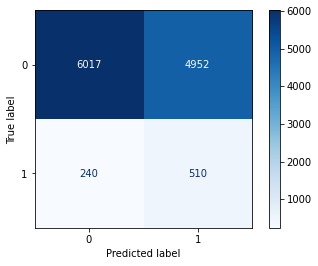

In [ ]:
evaluation(model, X_val_encoded, y_val)

## **Part 4. Undersampling**
- `RandomUnderSampler`를 사용하여 GBDT 모델을 다시 학습하세요.
  - `random_state=42`로 설정합니다.
  - 모델 학습 시 하이퍼파라미터는 **Part 2**와 동일하게 설정합니다. 
  - **Part 2**와 동일하게 early stopping을 적용하세요. 
- 모델의 성능을 확인하세요.
  - val set에 대하여 AUC score를 구하세요.
  - `classification_report()`를 사용하여 성능을 확인하세요.
  - confusion matrix를 그려 보세요.

##### **Q4. confusion matrix에서 TP 개수를 제출하세요.**

In [ ]:
# undersampling 적용
X_train_sampled, y_train_sampled = RandomUnderSampler(random_state=42).fit_resample(
    X_train_encoded, y_train
)

In [ ]:
# 기존 target class 
y_train.value_counts()

0    43875
1     2998
Name: is_claim, dtype: int64

In [ ]:
# undersampling 후 target class
y_train_sampled.value_counts()

0    2998
1    2998
Name: is_claim, dtype: int64

In [ ]:
# 모델 학습

model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    n_estimators=987654321,
    random_state=42
)

watchlist = [(X_train_sampled, y_train_sampled), (X_val_encoded, y_val)]

model.fit(
    X_train_sampled,
    y_train_sampled,
    eval_set=watchlist,
    early_stopping_rounds=50,  # 50 rounds 동안 성능 개선이 없으면 학습을 중지합니다.
)

[0]	validation_0-auc:0.69952	validation_1-auc:0.62872
[1]	validation_0-auc:0.71296	validation_1-auc:0.62442
[2]	validation_0-auc:0.72679	validation_1-auc:0.63029
[3]	validation_0-auc:0.73414	validation_1-auc:0.63646
[4]	validation_0-auc:0.74132	validation_1-auc:0.63579
[5]	validation_0-auc:0.74913	validation_1-auc:0.63553
[6]	validation_0-auc:0.75481	validation_1-auc:0.63670
[7]	validation_0-auc:0.75830	validation_1-auc:0.63675
[8]	validation_0-auc:0.75959	validation_1-auc:0.63649
[9]	validation_0-auc:0.76855	validation_1-auc:0.63352
[10]	validation_0-auc:0.77288	validation_1-auc:0.63230
[11]	validation_0-auc:0.78215	validation_1-auc:0.63352
[12]	validation_0-auc:0.78593	validation_1-auc:0.63156
[13]	validation_0-auc:0.79019	validation_1-auc:0.63059
[14]	validation_0-auc:0.79361	validation_1-auc:0.63275
[15]	validation_0-auc:0.79782	validation_1-auc:0.63069
[16]	validation_0-auc:0.80032	validation_1-auc:0.63142
[17]	validation_0-auc:0.80528	validation_1-auc:0.62956
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=987654321,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42, ...)

AUC Score: 0.6367030115173063 

              precision    recall  f1-score   support

           0       0.96      0.51      0.66     10969
           1       0.09      0.69      0.16       750

    accuracy                           0.52     11719
   macro avg       0.52      0.60      0.41     11719
weighted avg       0.90      0.52      0.63     11719
 



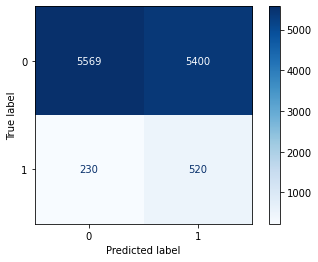

In [ ]:
evaluation(model, X_val_encoded, y_val)

## **Part 5. Oversampling**
- `SMOTE`를 사용하여 GBDT 모델을 다시 학습하세요.
  - `random_state=42`로 설정합니다.
  - 모델 학습 시 하이퍼파라미터는 **Part 2**와 동일하게 설정합니다. 
  - **Part 2**와 동일하게 early stopping을 적용하세요. 
- 모델의 성능을 확인하세요.
  - val set에 대하여 AUC score를 구하세요.
  - `classification_report()`를 사용하여 성능을 확인하세요.
  - confusion matrix를 그려 보세요.

##### **Q5. confusion matrix에서 TP 개수를 제출하세요.**

In [ ]:
X_train_sampled, y_train_sampled = SMOTE(random_state=42).fit_resample(
    X_train_encoded, y_train
)

In [ ]:
y_train.value_counts()

0    43875
1     2998
Name: is_claim, dtype: int64

In [ ]:
y_train_sampled.value_counts()

0    43875
1    43875
Name: is_claim, dtype: int64

In [ ]:
model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    n_estimators=987654321,
    random_state=42
)

watchlist = [(X_train_sampled, y_train_sampled), (X_val_encoded, y_val)]

model.fit(
    X_train_sampled,
    y_train_sampled,
    eval_set=watchlist,
    early_stopping_rounds=50,  # 50 rounds 동안 성능 개선이 없으면 학습을 중지합니다.
)

[0]	validation_0-auc:0.77261	validation_1-auc:0.59908
[1]	validation_0-auc:0.81384	validation_1-auc:0.61104
[2]	validation_0-auc:0.82345	validation_1-auc:0.61333
[3]	validation_0-auc:0.84998	validation_1-auc:0.60829
[4]	validation_0-auc:0.87009	validation_1-auc:0.61158
[5]	validation_0-auc:0.89226	validation_1-auc:0.61564
[6]	validation_0-auc:0.92088	validation_1-auc:0.61804
[7]	validation_0-auc:0.93446	validation_1-auc:0.62612
[8]	validation_0-auc:0.93997	validation_1-auc:0.62468
[9]	validation_0-auc:0.94291	validation_1-auc:0.62317
[10]	validation_0-auc:0.94343	validation_1-auc:0.61893
[11]	validation_0-auc:0.94982	validation_1-auc:0.62303
[12]	validation_0-auc:0.95461	validation_1-auc:0.62775
[13]	validation_0-auc:0.95526	validation_1-auc:0.62830
[14]	validation_0-auc:0.95815	validation_1-auc:0.62880
[15]	validation_0-auc:0.96062	validation_1-auc:0.63125
[16]	validation_0-auc:0.96217	validation_1-auc:0.62914
[17]	validation_0-auc:0.96266	validation_1-auc:0.63154
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=987654321,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42, ...)

AUC Score: 0.6401930288388489 

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     10969
           1       0.13      0.05      0.07       750

    accuracy                           0.92     11719
   macro avg       0.54      0.51      0.51     11719
weighted avg       0.89      0.92      0.90     11719
 



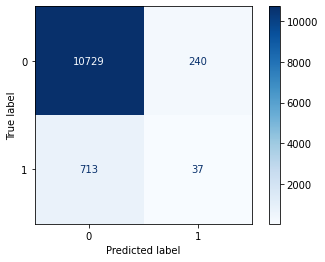

In [ ]:
evaluation(model, X_val_encoded, y_val)

## **Part 6. Oversampling + Undersampling**

- `SMOTEENN`을 사용하여 GBDT 모델을 다시 학습하세요.
  - `random_state=42`로 설정합니다.
  - 모델 학습 시 하이퍼파라미터는 **Part 2**와 동일하게 설정하고, `scale_pos_weight`를 사용하세요.  
  - **Part 2**와 동일하게 early stopping을 적용하세요. 
- 모델의 성능을 확인하세요.
  - val set에 대하여 AUC score를 구하세요.
  - `classification_report()`를 사용하여 성능을 확인하세요.
  - confusion matrix를 그려 보세요.

##### **Q6. confusion matrix에서 TP 개수를 제출하세요.**

In [ ]:
from imblearn.combine import SMOTEENN

X_train_sampled, y_train_sampled = SMOTEENN(random_state=42).fit_resample(
    X_train_encoded, y_train
)

In [ ]:
y_train.value_counts()

0    43875
1     2998
Name: is_claim, dtype: int64

In [ ]:
y_train_sampled.value_counts()

1    32722
0    26266
Name: is_claim, dtype: int64

In [ ]:
model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    n_estimators=987654321,
    random_state=42,
    scale_pos_weight=(y_train_sampled == 0).sum() / (y_train_sampled == 1).sum(),
)

watchlist = [(X_train_sampled, y_train_sampled), (X_val_encoded, y_val)]

model.fit(
    X_train_sampled,
    y_train_sampled,
    eval_set=watchlist,
    early_stopping_rounds=50,  # 50 rounds 동안 성능 개선이 없으면 학습을 중지합니다.
)

[0]	validation_0-auc:0.80551	validation_1-auc:0.60315
[1]	validation_0-auc:0.84047	validation_1-auc:0.61698
[2]	validation_0-auc:0.87014	validation_1-auc:0.61837
[3]	validation_0-auc:0.88950	validation_1-auc:0.62442
[4]	validation_0-auc:0.89472	validation_1-auc:0.62498
[5]	validation_0-auc:0.89916	validation_1-auc:0.62334
[6]	validation_0-auc:0.90579	validation_1-auc:0.62651
[7]	validation_0-auc:0.91279	validation_1-auc:0.62484
[8]	validation_0-auc:0.92265	validation_1-auc:0.62189
[9]	validation_0-auc:0.93810	validation_1-auc:0.62703
[10]	validation_0-auc:0.94295	validation_1-auc:0.62820
[11]	validation_0-auc:0.94881	validation_1-auc:0.62709
[12]	validation_0-auc:0.95035	validation_1-auc:0.62402
[13]	validation_0-auc:0.95092	validation_1-auc:0.62613
[14]	validation_0-auc:0.96060	validation_1-auc:0.62872
[15]	validation_0-auc:0.96585	validation_1-auc:0.63106
[16]	validation_0-auc:0.96819	validation_1-auc:0.63237
[17]	validation_0-auc:0.96890	validation_1-auc:0.63188
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=987654321,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42, ...)

AUC Score: 0.637283860576777 

              precision    recall  f1-score   support

           0       0.94      0.97      0.95     10969
           1       0.14      0.07      0.09       750

    accuracy                           0.91     11719
   macro avg       0.54      0.52      0.52     11719
weighted avg       0.89      0.91      0.90     11719
 



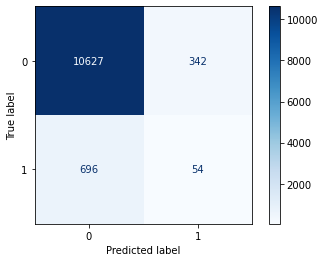

In [ ]:
evaluation(model, X_val_encoded, y_val)

# **🥇 도전 과제**

지금까지 sprint3의 모든 도전과제를 수행하였다면, 의미있는 인사이트를 도출할 수 있도록 EDA나 다양한 모델 학습, 하이퍼파라미터 튜닝 등을 추가하여 더 develop 해 보시기 바랍니다. 
또한 Readme를 보완(또는 작성)하여 sprint3 내용을 복습해 보세요.

여러분의 프로젝트를 응원합니다!